# Introduction
Pipeline from the paper [Persistence diagrams as morphological signatures of cells: A method to measure and compare cells within a population](https://files.yossi.eu/manuscripts/2310.20644.pdf) by Yossi Bokor Bleile, Patrice Koehl, and Florian Rehfeldt.

The following packages need to be installed: 
- [Correa](correa.yossi.eu)
- plotly
- pandas
- sklearn
- numpy
- matplotlib

We begin the analysis by obtaining a persistence diagram for each cell in the population, as a summary of the morophology of the cell.


## Import modules

In [1]:
import correa
import pandas
import plotly.express as px
import plotly.figure_factory as ff		
import plotly.io as pio
from sklearn import manifold, cluster, decomposition, metrics, preprocessing
import numpy
import scipy.cluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import ClusterWarning
from matplotlib import pyplot as plt
import matplotlib
from scipy.spatial.distance import squareform
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

## Custom functions for the analysis

We next define some custom functions to make creating the dendrograms easier.


In [58]:
#set colours
def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)
hex_list = []
for c in px.colors.qualitative.Set1:
	hex_list.append(rgb_to_hex(int(c.replace("rgb(","").replace(")","").split(",")[0]),int(c.replace("rgb(","").replace(")","").split(",")[1]), int(c.replace("rgb(","").replace(")","").split(",")[2])))
 
 
def plot_dendrogram(model, **kwargs):
	# Create linkage matrix and then plot the dendrogram
	# create the counts of samples under each node
	counts = numpy.zeros(model.children_.shape[0])
	n_samples = len(model.labels_)
	for i, merge in enumerate(model.children_):
		current_count = 0
		for child_idx in merge:
			if child_idx < n_samples:
				current_count += 1  # leaf node
			else:
				current_count += counts[child_idx - n_samples]
		counts[i] = current_count
	linkage_matrix = numpy.column_stack([model.children_, model.distances_, counts]).astype(float)
	# Plot the corresponding dendrogram
	plt.figure(figsize=(2000,2000))
	plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
	plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
	dendrogram(linkage_matrix, **kwargs)

def generate_rand_index(cluster_df : pandas.DataFrame, to_compare : list):
	r_ind = pandas.DataFrame(columns=to_compare, index=to_compare)
	for i in to_compare:
		for j in to_compare:
			r_ind[i].loc[j] = metrics.rand_score(cluster_df[i], cluster_df[j])
	return r_ind

def population_percentages(df : pandas.DataFrame, clustering : str):
	labels = [int(c) for c in df[clustering]]
	counts = [0 for i in range(max(labels)+1)]
	for l in labels:
		counts[l]+=1
	percentages = [c/len(labels) for c in counts]
	return percentages, counts

def analysis(dists : pandas.DataFrame, cluster_numbers : list,  name : str,  dir : str, group = False, exclude : list = [], show2d = False, showElbow=False, colour_list=hex_list):
	#colour order is red, purple, blue, green
	if group == False:
		inds = dists.index
		dists = dists
		if len(exclude) != 0:
			inds = []
			for f in dists.index:
				if f not in exclude:
					inds.append(f)
			dists = dists[inds].loc[inds]
	else:
		inds = []
		for f in dists.index:
			if group in f and f not in exclude:
				inds.append(f)
		dists = dists[inds].loc[inds]
	df = pandas.DataFrame(index=inds)
	embed = manifold.MDS(3, dissimilarity='precomputed', random_state=1, normalized_stress="auto").fit_transform(dists.to_numpy())
	df["x"] = embed[:,0]
	df["y"] = embed[:,1]
	df["z"] = embed[:,2]
	silhouette_samples = []
	silhouette_score = []
	linkage_matrices = []
	avg = cluster.AgglomerativeClustering(distance_threshold=None, n_clusters=4, linkage="average")
	avg = avg.fit(dists.to_numpy())
	dflt = "#000000"
	D_leaf_colors = {dists.index[i]: colour_list[avg.labels_[i]] for i in range(len(avg.labels_))}
	#Average
	for link in ["average", "complete", "single", "ward"]:
		linkage = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=link)
		linkage = linkage.fit(dists.to_numpy())
		counts = numpy.zeros(linkage.children_.shape[0])
		n_samples = len(linkage.labels_)
		for i, merge in enumerate(linkage.children_):
			current_count = 0
			for child_idx in merge:
				if child_idx < n_samples:
					current_count += 1  # leaf node
				else:	
					current_count += counts[child_idx - n_samples]
			counts[i] = current_count
		linkage_matrix = numpy.column_stack([linkage.children_, linkage.distances_, counts]).astype(float)
		linkage_matrices.append(linkage_matrix)
		# notes:
		# * rows in Z correspond to "inverted U" links that connect clusters
		# * rows are ordered by increasing distance
		# * if the colors of the connected clusters match, use that color for link
		link_cols = {}
		for i, i12 in enumerate(linkage_matrix[:,:2].astype(int)):
			c1, c2 = (link_cols[x] if x > len(linkage_matrix) else D_leaf_colors[dists.index[x]] for x in i12)
			if c1 == c2:
				link_cols[i+1+len(linkage_matrix)] = c1
			else:
				if i12[0] < n_samples:
					link_cols[i+1+len(linkage_matrix)] = D_leaf_colors[dists.index[i12[0]]]
				elif i12[1] < n_samples:
					link_cols[i+1+len(linkage_matrix)] = D_leaf_colors[dists.index[i12[1]]]
				else:
					link_cols[i+1+len(linkage_matrix)] = dflt
		# Dendrogram
		D = dendrogram(Z=linkage_matrix, labels=dists.index, color_threshold=None, no_labels=True, link_color_func=lambda x: link_cols[x])
		#plt.xlabel(name+" "+link)
		plt.yticks([])
		plt.savefig(dir+"/"+name.replace(" ","_")+"_"+link+"_dendrogram.png")
		plt.show()
	sse = []
	for link in ["average", "complete", "single", "ward"]:
		for k in cluster_numbers:
			linkage = cluster.AgglomerativeClustering(distance_threshold=None, n_clusters=k, linkage=link)
			linkage = linkage.fit(dists.to_numpy())
			labels = linkage.labels_
			labels = [str(c) for c in labels]
			df[link+str(k)] = labels
			sil_score = metrics.silhouette_score(dists, df[link+str(k)], metric="precomputed")
			silhouette_score.append(sil_score)
			sil_samps = metrics.silhouette_samples(dists, df[link+str(k)], metric="precomputed")
			silhouette_samples.append([sil_samps])
			fig = px.scatter(df, x='x', y='y',color=link+str(k), title=name+" ("+link+" "+str(k)+")", hover_data=[df.index], width=800, height=600, color_discrete_map={
                "0": hex_list[0], "1": hex_list[1],"2": hex_list[1],"2": hex_list[2], "3": hex_list[3]})
			fig.update_traces(marker={'size': 5})
			if show2d:
				fig.show()
			fig.write_image(dir+"/"+name.replace(" ","_")+"_"+link+str(k)+"_2D.png")
	if showElbow:
		plt.plot(cluster_numbers, sse)
		plt.title("Elbow Method")
		plt.xlabel("Number of Clusters")
		plt.xticks(cluster_numbers)
		plt.ylabel("SSE")
		plt.savefig(dir+"/"+name.replace(" ","_")+"_kmeans-elbow.png")
		fig.show()
	df.to_csv(dir+"/"+name.replace(" ","_")+"_df.csv")
	rand_ind_tables_latex = []
	percentages_dict = {}
	for k in cluster_numbers:
		rand_ind_tables_latex.append(generate_rand_index(df, ["average"+str(k), "complete"+str(k), "single"+str(k),"ward"+str(k)]).to_latex())
		print("cluster sizes and percentages are:")
		percentages_dict["average{}".format(k)], counts = population_percentages(df, "average"+str(k))
		print("average{}".format(k), counts, percentages_dict["average{}".format(k)])
		percentages_dict["complete{}".format(k)], counts = population_percentages(df, "complete"+str(k))
		print("complete{}".format(k), counts, percentages_dict["complete{}".format(k)])
		percentages_dict["single{}".format(k)], counts = population_percentages(df, "single"+str(k))
		print("single{}".format(k), counts, percentages_dict["single{}".format(k)])
		percentages_dict["ward{}".format(k)], counts = population_percentages(df, "ward"+str(k))
		print("ward{}".format(k), counts, percentages_dict["ward{}".format(k)])
		#percentages_dict["kmeans++{}".format(k)] = population_percentages(df, "kmeans++"+str(k))
		#print("kmeans++{}".format(k), percentages_dict["kmeans++{}".format(k)])
	return df, silhouette_score, silhouette_samples, rand_ind_tables_latex, percentages_dict, dists, linkage_matrices

def get_main_population(analysis, cluster : str, dists : pandas.DataFrame):
	main_id = analysis[4][cluster].index(max(analysis[4][cluster]))
	main_index= analysis[0].index[analysis[0][cluster] == str(main_id)]
	return dists[main_index].loc[main_index]

def purity(merges, clus : set, n_objs):
	dct = dict([(i, {i}) for i in range(n_objs)])
	for i, row in enumerate(merges, n_objs):
		dct[i] = dct[row[0]].union(dct[row[1]])
		del dct[row[0]]
		del dct[row[1]]
		for c in list(dct.values()):
			if clus.issubset(c):
				return c, (n_objs-len(c))/(n_objs-len(clus))

First, we will load the file containing the center of the nucleus for each cell.

In [2]:
centers = pandas.read_csv("X1/Nuc_Cm_X1.csv", index_col="filename") #Load the center of the nucleus, labled by the nucleus file name

Next, for each cell will caculate the persistence diagram using a radial function based at the center of the nucles. We do need to translate the center of the nucleus into the same frame as the contour is in. This is due to the way FilamentSensor extracts the contour of each cell in a directory.

In [22]:
import plotly.graph_objects as go
width=1500
height=1692
i = 1
contour = pandas.read_csv("X1/cell/csv_contour/"+str("%03d" % (2*i+1))+"_contour.csv",header=None)

center = pandas.DataFrame([[769.049, 855.158]], columns=["x", "y"])
fig_data = px.scatter(contour, x=0, y=1, width=800, height=600).data
fig_data = fig_data + px.scatter(center, x="x", y="y", width=800, height=600).data
fig = go.Figure(fig_data)
fig.show()

In [24]:
contours = []
names = []
width=1500
height=1692
for i in reversed(range(140)):
	c_i = correa.create_polygon_focal_point("X1/cell/csv_contour/"+str("%03d" % (2*i+1))+"_contour.csv", [centers.loc[2*i]["X_m"], centers.loc[2*i]["Y_m"]])
	c_i.persistence_diagram()
	contours.append(c_i)
	names.append(str("%03d" % (2*i+1)))
 


Initial number of points in polygon      : 1974
Number of points in polygon after cleanup: 1003


Initial number of points in polygon      : 2284
Number of points in polygon after cleanup: 1171


Initial number of points in polygon      : 3891
Number of points in polygon after cleanup: 2174


Initial number of points in polygon      : 2717
Number of points in polygon after cleanup: 1538


Initial number of points in polygon      : 1808
Number of points in polygon after cleanup: 1038


Initial number of points in polygon      : 2877
Number of points in polygon after cleanup: 1485


Initial number of points in polygon      : 2510
Number of points in polygon after cleanup: 1396


Initial number of points in polygon      : 4088
Number of points in polygon after cleanup: 2314


Initial number of points in polygon      : 1512
Number of points in polygon after cleanup: 835


Initial number of points in polygon      : 1778
Number of points in polygon after cleanup: 1048


Initial number of po

Once we have a persistence diagram for each cell summarising its morphology, we compute the Wasserstein distance between each pair of persistence diagrams as a (dis)similarity score for each pair of cells.

In [97]:
w_distances = numpy.zeros((140,140))
for i in range(140):
	for j in range(i,140):
		dist_ij = correa.wasserstein_distance(contours[i], contours[j], q=2)
		dist_ji = correa.wasserstein_distance(contours[j], contours[i], q=2)
		dist = (dist_ij+dist_ji)/2
		print("for {} and {} dist_ij is {} and dist_ji is {} so we have dist {}".format(i,j,dist_ij,dist_ji,dist))
		w_distances[i,j] = dist
		w_distances[j,i] = dist

for 0 and 0 dist_ij is 0.0 and dist_ji is 0.0 so we have dist 0.0
for 0 and 1 dist_ij is 96.31703375944008 and dist_ji is 96.31719266907523 so we have dist 96.31711321425766
for 0 and 2 dist_ij is 261.16454236115004 and dist_ji is 261.1538852069718 so we have dist 261.1592137840609
for 0 and 3 dist_ij is 120.57027508831376 and dist_ji is 120.56557232680102 so we have dist 120.56792370755738
for 0 and 4 dist_ij is 233.05972782427372 and dist_ji is 233.05990889639523 so we have dist 233.05981836033448
for 0 and 5 dist_ij is 141.5353551081951 and dist_ji is 141.5380890999434 so we have dist 141.53672210406924
for 0 and 6 dist_ij is 135.79445946609107 and dist_ji is 135.78755021576822 so we have dist 135.79100484092965
for 0 and 7 dist_ij is 467.11173028333315 and dist_ji is 467.1383919891793 so we have dist 467.12506113625625
for 0 and 8 dist_ij is 139.44589469109778 and dist_ji is 139.4447575399414 so we have dist 139.4453261155196
for 0 and 9 dist_ij is 224.59119224569704 and dist_ji is

KeyboardInterrupt: 

Next we display a heatmap of the Wasserstein distances.

In [91]:
px.imshow(w_distances,width=500, height=500)

In [92]:
X1_dists = pandas.DataFrame(w_distances, columns=names, index=names)

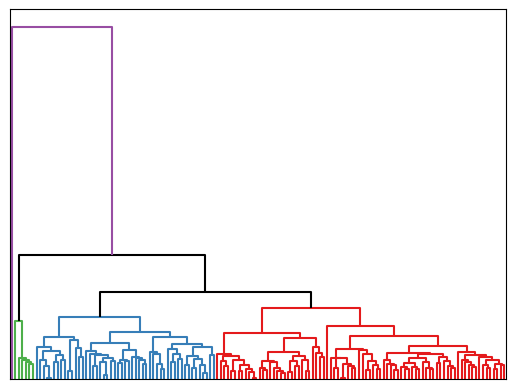

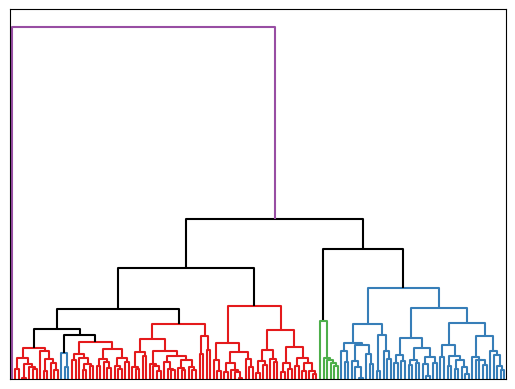

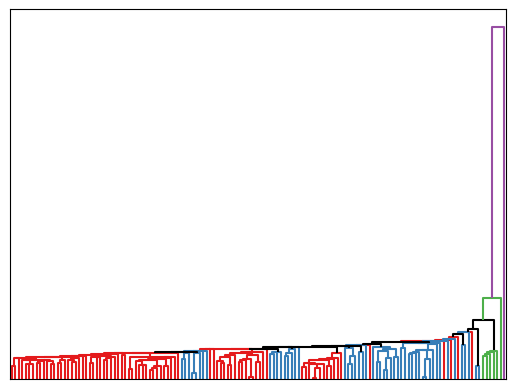

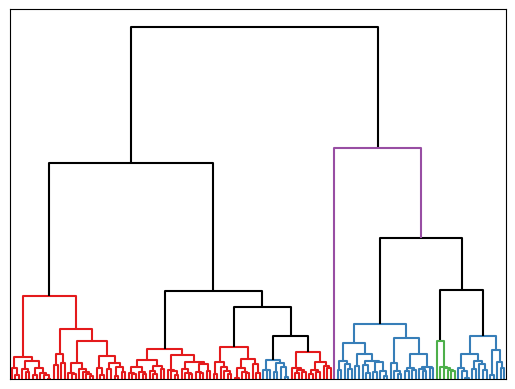

cluster sizes and percentages are:
average3 [133, 1, 6] [0.95, 0.007142857142857143, 0.04285714285714286]
complete3 [53, 1, 86] [0.37857142857142856, 0.007142857142857143, 0.6142857142857143]
single3 [138, 1, 1] [0.9857142857142858, 0.007142857142857143, 0.007142857142857143]
ward3 [91, 48, 1] [0.65, 0.34285714285714286, 0.007142857142857143]
cluster sizes and percentages are:
average4 [82, 51, 6, 1] [0.5857142857142857, 0.36428571428571427, 0.04285714285714286, 0.007142857142857143]
complete4 [86, 6, 47, 1] [0.6142857142857143, 0.04285714285714286, 0.3357142857142857, 0.007142857142857143]
single4 [133, 5, 1, 1] [0.95, 0.03571428571428571, 0.007142857142857143, 0.007142857142857143]
ward4 [48, 58, 1, 33] [0.34285714285714286, 0.4142857142857143, 0.007142857142857143, 0.2357142857142857]
cluster sizes and percentages are:
average5 [51, 51, 6, 1, 31] [0.36428571428571427, 0.36428571428571427, 0.04285714285714286, 0.007142857142857143, 0.22142857142857142]
complete5 [47, 56, 30, 1, 6] [0

In [93]:
X1 = analysis(X1_dists, [3,4,5], "X1", "X1")

The heatmap and all 4 dendrograms indicate there is an outlier, so lets identify which cell this is. Using `average4` the outlier has cluster number 3.

In [75]:
for i in X1[0].index:
	if int(X1[0].loc[i]["average4"]) == 3:
		print(i)

031


We can use the `analysis` command with the `exclude` parameter to exclude cell `031` from our analysis.

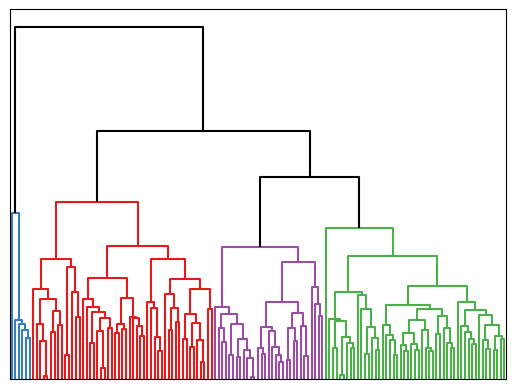

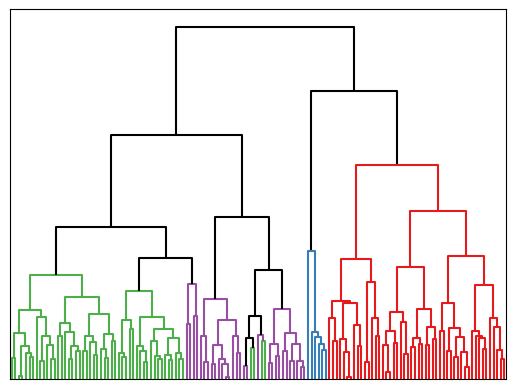

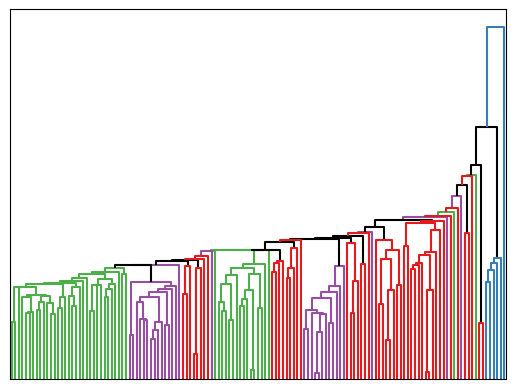

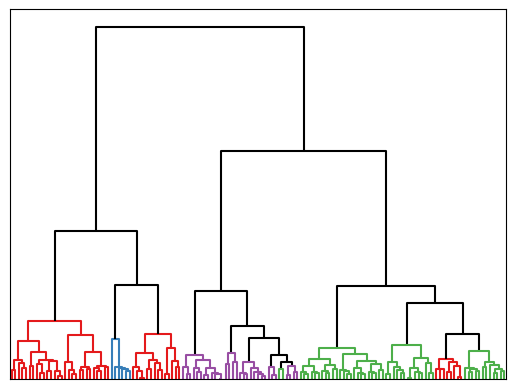

cluster sizes and percentages are:
average3 [82, 6, 51] [0.5899280575539568, 0.04316546762589928, 0.3669064748201439]
complete3 [83, 50, 6] [0.5971223021582733, 0.3597122302158273, 0.04316546762589928]
single3 [133, 1, 5] [0.9568345323741008, 0.007194244604316547, 0.03597122302158273]
ward3 [48, 58, 33] [0.34532374100719426, 0.4172661870503597, 0.23741007194244604]
cluster sizes and percentages are:
average4 [51, 6, 51, 31] [0.3669064748201439, 0.04316546762589928, 0.3669064748201439, 0.22302158273381295]
complete4 [50, 30, 6, 53] [0.3597122302158273, 0.2158273381294964, 0.04316546762589928, 0.381294964028777]
single4 [131, 2, 5, 1] [0.9424460431654677, 0.014388489208633094, 0.03597122302158273, 0.007194244604316547]
ward4 [20, 58, 33, 28] [0.14388489208633093, 0.4172661870503597, 0.23741007194244604, 0.2014388489208633]
cluster sizes and percentages are:
average5 [6, 37, 51, 31, 14] [0.04316546762589928, 0.26618705035971224, 0.3669064748201439, 0.22302158273381295, 0.10071942446043165

In [95]:
X1_main = analysis(X1_dists, [3,4,5], "X1", "X1", exclude=["031"])

In [86]:
n_c = X1_main[0].shape[0]
print(n_c)
for k in range(4):
	clus = set(())
	for i in range(len(X1_main[0]["average4"])):
		if X1_main[0]["average4"].iloc[i] == str(k):
			clus.add(i)
	print("cluster "+str(k))
	print("average: "+str(purity(X1_main[6][0], clus, n_c)[1]))
	print("complete: "+str(purity(X1_main[6][1], clus, n_c)[1]))
	print("single: "+str(purity(X1_main[6][2], clus, n_c)[1]))
	print("ward: "+str(purity(X1_main[6][3], clus, n_c)[1]))


139
cluster 0
average: 1.0
complete: 0.0
single: 0.06818181818181818
ward: 0.0
cluster 1
average: 1.0
complete: 1.0
single: 0.0
ward: 1.0
cluster 2
average: 1.0
complete: 0.6363636363636364
single: 0.09090909090909091
ward: 0.5454545454545454
cluster 3
average: 1.0
complete: 0.5185185185185185
single: 0.1111111111111111
ward: 0.9814814814814815
